In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#Classify particles into gamma(signal) or hadrons(background).
#The data set was generated by a Monte Carlo program, Corsika, described in D. Heck et al., CORSIKA, A Monte Carlo code to simulate extensive air showers, Forschungszentrum Karlsruhe FZKA 6019 (1998).

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Read the csv data as a DataFrame
df = pd.read_csv('telescope_data.csv', index_col=0)

# Remove null and na values
df.dropna()

# Print the DataFrame head
print(df.head())

# Extract the class classes
classes = df['class']
data_matrix = df.drop(columns='class')

print()
print(data_matrix)

    fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans   fAlpha     fDist class
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027  40.0920   81.8828     g
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   6.3609  205.2610     g
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160  76.9600  256.7880     g
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513  10.4490  116.7370     g
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   4.6480  356.4620     g

        fLength    fWidth   fSize   fConc  fConc1     fAsym   fM3Long  fM3Trans   fAlpha     fDist
0       28.7967   16.0021  2.6449  0.3918  0.1982   27.7004   22.0110   -8.2027  40.0920   81.8828
1       31.6036   11.7235  2.5185  0.5303  0.3773   26.2722   23.8238   -9.9574   6.3609  205.2610
2      162.0520  136.0310  4.0612  0.0374  0.0187  116.7410  -64.8580  -45.2160  76.9600  256.7880
3  

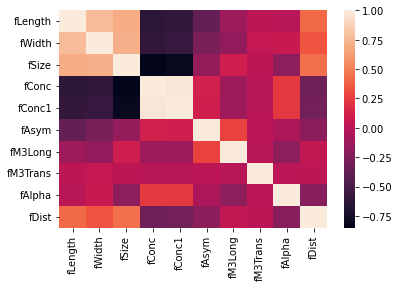

In [49]:
# Use the `.corr()` method on `data_matrix` to get the correlation matrix 
correlation_matrix = data_matrix.corr()

ax = plt.axes()
sns.heatmap(correlation_matrix, ax=ax) #, cmap='Greens'
ax.set_title('')
plt.show()

In [50]:
# Perform eigendecomposition using `np.linalg.eig` 
eigenvalues, eigenvectors = np.linalg.eig(correlation_matrix)
print(f'Eigenvalues length: {eigenvalues.size}, Original Number of Features: {data_matrix.shape[1]}')

# Order the eigenvalues by ordering the indices of the eigenvalues using `argsort`, and use [::-1] to order them from greatest to smallest
indices = eigenvalues.argsort()[::-1]  
eigenvalues = eigenvalues[indices]
eigenvectors = eigenvectors[:, indices]

print(eigenvalues.shape, eigenvectors.shape)

Eigenvalues length: 10, Original Number of Features: 10
(10,) (10, 10)


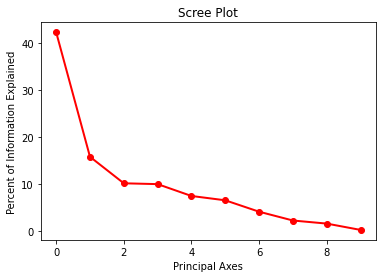

In [51]:
# Find the percentages of information for each eigenvector, which is generated by the proportion of its eigenvalues to the sum of all eigenvalues
information_proportions = eigenvalues / eigenvalues.sum()
information_percents = information_proportions * 100

# Plot the principal axes vs the information proportions for each principal axis
plt.figure()
plt.plot(information_percents, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Axes')
plt.ylabel('Percent of Information Explained')
plt.show()

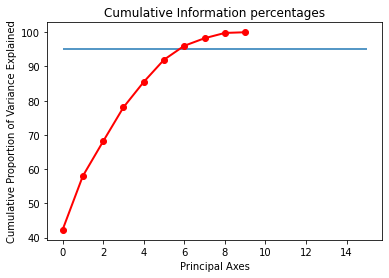

In [52]:
# Find the cumulative sum of the percentages
cumulative_information_percents = np.cumsum(information_percents)

# Plot the cumulative percentages array
plt.figure()
plt.plot(cumulative_information_percents, 'ro-', linewidth=2)

# Also plot a horizontal line indicating the 95% mark, and a vertical line for the third principal axis
plt.hlines(y=95, xmin=0, xmax=15)
#plt.vlines(x=3, ymin=0, ymax=100)
plt.title('Cumulative Information percentages')
plt.xlabel('Principal Axes')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.show()

In [53]:
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

# Standardize the data matrix
mean = data_matrix.mean(axis=0)
sttd = data_matrix.std(axis=0)
data_matrix_standardized = (data_matrix - mean) / sttd

In [54]:
# Find the principal components
pca = PCA()

# Fit the standardized data and calculate the principal components
principal_components = pca.fit_transform(data_matrix_standardized)
print(f'Number of features in the data matrix: {principal_components.shape[1]}')
print(f'Number of features in the principal components: {data_matrix.shape[1]}')

Number of features in the data matrix: 10
Number of features in the principal components: 10


In [55]:
# Find the eigenvalues from the singular values
singular_values = pca.singular_values_
eigenvalues = singular_values ** 2

# Eigenvectors are in the property `.components_` as row vectors. To turn them into column vectors, transpose them using the NumPy method `.T`.
eigenvectors = pca.components_.T

In [56]:
# Get the variance ratios from the `explained_variance_ratio_`
principal_axes_variance_ratios = pca.explained_variance_ratio_
principal_axes_variance_percents = principal_axes_variance_ratios * 100

In [57]:
# Calculating principal components with 2 components
# Initialize a PCA object with 2 components
pca = PCA(n_components=2) 
 
# Fit the standardized data and calculate the principal components
principal_components = pca.fit_transform(data_matrix_standardized)
 
# Print the DataFrame
print(f'Number of Principal Components Features: {principal_components.shape[1]}')
print(f'Number of Original Data Features: {data_matrix_standardized.shape[1]}')

Number of Principal Components Features: 2
Number of Original Data Features: 10


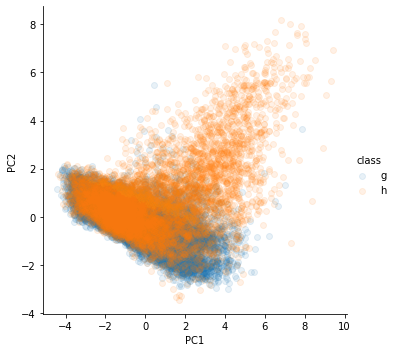

In [58]:
# Plot the principal components as a scatterplot
principal_components_data = pd.DataFrame({
    'PC1': principal_components[:, 0],
    'PC2': principal_components[:, 1],
    'class': classes,
})

sns.lmplot(x='PC1', y='PC2', data=principal_components_data, hue='class', fit_reg=False, scatter_kws={'alpha':0.1})
plt.show()

# We will use the one-hot-encoded classes as the y
y = classes.astype('category').cat.codes

In [59]:
# Using the original features 
# Select two features from the original data
first_two_original_features = [0, 1]
X_original = data_matrix_standardized.iloc[:, first_two_original_features]
 
# Split the data intro 33% testing and the rest training
X_train, X_test, y_train, y_test = train_test_split(X_original, y, test_size=0.33)
 
# Create a Linear Support Vector Classifier
svc_2 = LinearSVC()
svc_2.fit(X_train, y_train)
 
# Generate a score for the testing data
score_2 = svc_2.score(X_test, y_test)
print(f'Score for model with 2 randomly selected features: {score_2}')

Score for model with 2 randomly selected features: 0.7180181615421379


In [60]:
# Get principal components with 2 features 
# Perform PCA using 2 components
pca_1 = PCA(n_components=2) 
 
# Use the principal components as X and split the data into 33% testing and the rest training
X = pca_1.fit_transform(data_matrix_standardized) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
 
# Create a Linear Support Vector Classifier
svc_1 = LinearSVC(tol=1e-5)
svc_1.fit(X_train, y_train) 
 
# Generate a score for the testing data
score_1 = svc_1.score(X_test, y_test)
print(f'Score for model with 2 PCA features: {score_1}')

Score for model with 2 PCA features: 0.7465349689342042
